# ACCURACY OF LINEAR MODELS

This notebook introduces core elements of the CalTech control package and provides various examples of using the with Tellurium.

# Preliminaries

In [4]:
!pip install -q control
!pip install -q tellurium

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Antimony Models

### Linear Model

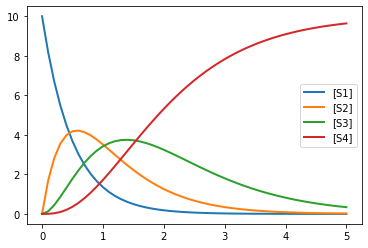

In [5]:
LINEAR_MDL = """
JL1: S1 -> S2; k1*S1
JL2: S2 -> S3; k2*S2
JL3: S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)

### Nonlinear Model

This is a non-linear model because of the presence of a reaction with two reactions, ``JN2``,
with mass action kinetics.

Note: The rate law for JN4 does not follow mass action kinetics due to a typo. For consistency with the lecture 9 material, this error was not addressed in this notebook and is carried over into HW1

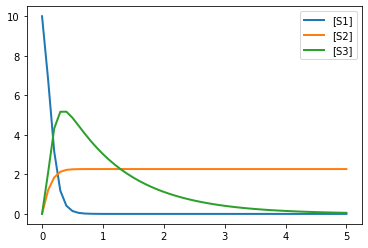

In [6]:
NONLINEAR_MDL = """
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR_RR = te.loada(NONLINEAR_MDL)
NONLINEAR_DATA = NONLINEAR_RR.simulate()
NONLINEAR_RR.plot(NONLINEAR_DATA)

In [7]:
NONLINEAR_RR.model.getFloatingSpeciesIds()

['S1', 'S2', 'S3']

### Nonlinear Step Model

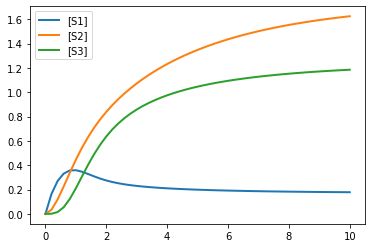

In [8]:
NONLINEAR_STEP_MDL = """
JN0: -> S1; 1
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 0
S2 = 0
S3 = 0
"""
rr = te.loada(NONLINEAR_STEP_MDL)
rr.simulate(0, 10)
rr.plot()

## Helpers

In [9]:
def getStateDct(time, roadrunner=NONLINEAR_RR):
    """
    Retrieves the value of state at the specified time.
    Changes the time of the roadrunner.
    
    Parameters
    ----------
    time: float
    roadrunner: ExtendedRoadrunner
    
    Returns
    -------
    dict
        key: species name
        value: species value
    """
    roadrunner.reset()
    if time > 0:
        roadrunner.simulate(0, time)
    species_lst = roadrunner.getFloatingSpeciesIds()
    dct = {s: roadrunner[s] for s in species_lst}
    return dct
        
# Tests
dct = getStateDct(0)
assert(len(dct) == 3)
dct1 = getStateDct(1)  # Get different values at a different time
assert(all([dct[s] != dct1[s] for s in dct.keys()]))
print("OK!")

OK!


In [10]:
def getStateValues(time, **kwargs):
    """
    Gets the values of state at the specified time.
    
    Parameters
    ----------
    time: float
    kwargs: dict
        keyword arguments for getStateDct
        
    Returns
    -------
    np.array
    """
    return np.array(list(getStateDct(time, **kwargs).values()))
        
# Tests
arr = getStateValues(0)
assert(isinstance(arr, np.ndarray))
assert(len(arr) == 3)
print("OK!")

OK!


In [11]:
def plotRR(roadrunner=NONLINEAR_RR, is_plot=True):
    """
    Plots species from running a simulation.
    """
    roadrunner.reset()
    roadrunner.simulate(0, 5, 100)
    if is_plot:
        roadrunner.plot()

# Tests
plotRR(is_plot=False)
print("OK!")

OK!


## Constants

In [12]:
# Find the values of the species at time 0.3
print(getStateDct(0.3))

{'S1': 1.177182300649287, 'S2': 2.1301804829093776, 'S3': 5.166698621646738}


# Constructing a Linear Approximation

Here, we show how to construct a linear approximation for a nonlinear reaction network.
The running example is ``NONLINEAR_MDL``.

The state vector is ${\bf x} = [S_1, S_2, S_3]^T$.

1. Choose an operating point, $\bar{\bf x}$.
1. Calculate the Jacobian, ${\bf A}$, of the system equations at the operating point.
1. Solve the linear system $\dot{\tilde {\bf x}}  = {\bf A} {\tilde {\bf x}}$ to obtain $\tilde {\bf x} (t)$.
1. Calculate the approximation for ${\bf x}(t) \approx \bar{\bf x} + \tilde{\bf x}(t)$.

## 1: Choose an operating point

In the sequel, we'll use $\bar{x} = [ \bar{S}_1, \bar{S}_2, \bar{S}_3 ]^T = [1.18,~ 2.13,~ 5.17]^T$.
We use $N$ to denote the number of states.

$\tilde {\bf x} = {\bf x} - \bar{ \bf x}$

In [13]:
OP_TIME = 1.0
OP_VEC = getStateValues(OP_TIME)
NUM_STATE = len(OP_VEC)
X0 = getStateValues(0)  # Initial values for simulation from time 0
print(OP_VEC)

[1.39121468e-03 2.26971483e+00 3.02738361e+00]


## 2: Calculate the Jacobian at the operating point

In [14]:
# This would probably make for a very useful function...
NONLINEAR_RR.reset()
NONLINEAR_RR.simulate(0,OP_TIME)
NONLINEAR_RR.getFullJacobian()

            S1,          S2,          S3
S1 [[ -8.43196, -0.00208682, -0.00139121],
S2  [  0.10912, -0.00208682, 0.000695607],
S3  [  8.70002,  0.00626047,     -1.0007]]

## 3: Solve the linear system for $\tilde{x}$

We'll use the ``control`` package to construct a transfer function.
This means that we need to specify the input and output.
For this example, the input is $S_1$ and the output is $S_3$.
So, $G(s) = \frac{S_3(s)}{S_1(s)}$.

The first substep is to create a ``StateSpace`` object
that has $S_1$ as its input and $S_3$ as its output.

\begin{eqnarray}
\dot {\tilde {\bf x}} &=& A \tilde{ {\bf x}} + {\bf B} u \\
y & = & {\bf C} \tilde{ {\bf x}} + {\bf D}  u \\
\end{eqnarray}

Note that $y$, ${\bf x}$, and $u$ are a function of time.
Beause this is a Single Input Single Output (SISO) system, the input $u$ and the output $y$ are scalars for any time $t$.

In [15]:
# Obtain the Jacobian at the operating point
NONLINEAR_RR.reset()
NONLINEAR_RR.simulate(0, OP_TIME)
A = NONLINEAR_RR.getFullJacobian()
A

            S1,          S2,          S3
S1 [[ -8.43196, -0.00208682, -0.00139121],
S2  [  0.10912, -0.00208682, 0.000695607],
S3  [  8.70002,  0.00626047,     -1.0007]]

### Construct the state space matrices

Now, we have to construct ${\bf B}$, ${\bf C}$, ${\bf D}$.

${\bf B}$ has dimension $N \times 1$ since there is one input.
This input is $S_1$.
So, $u$ should only affect $S_1$.
That is,
${\bf B} =
\begin{bmatrix}
1 \\
0 \\
0\\
\end{bmatrix}.
$

In [16]:
B = np.array([1, 0, 0])
B = np.reshape(B, (NUM_STATE, 1))
np.shape(B)

(3, 1)

${\bf C}$ has dimension $1 \times N$ since there is only one output.
This output is $S_1$.
So, we want to select only $S_3$ output of the state vector.
That is,
${\bf C} =
\begin{bmatrix}
0 \\
0 \\
1\\
\end{bmatrix}.
$

In [17]:
C = np.array([0, 0, 1])
C = np.reshape(C, (1, NUM_STATE))
np.shape(C)

(1, 3)

${\bf D}$ is not used in this model, and so it should be all zeroes.
It must have the same number of rows as there are outputs, and the same number of columns as there are inputs.
So, ${\bf D} = 0$.

In [18]:
D = 0

### Construct the ``control`` objects

In [19]:
NONLINEAR_SS_1_3 = control.StateSpace(A, B, C, D)
print(NONLINEAR_SS_1_3)

A = [[-8.43195585e+00 -2.08682202e-03 -1.39121468e-03]
     [ 1.09119564e-01 -2.08682202e-03  6.95607339e-04]
     [ 8.70002492e+00  6.26046606e-03 -1.00069561e+00]]

B = [[1.]
     [0.]
     [0.]]

C = [[0. 0. 1.]]

D = [[0.]]



### Run a simulation With the Transfer Function Object

We will do the simulation using ``control.

In [20]:
times = [0.1*v for v in range(51)]
result = control.forced_response(NONLINEAR_SS_1_3, times, X0=getStateValues(0))

Note that initial conditions are in real units not nominal units.
Also, ``X0`` $=\bar{\bf x}$.

(0.0, 10.0)

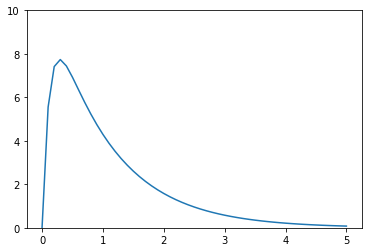

In [21]:
plt.plot(result.t.flatten(), result.y.flatten())
plt.ylim([0, 10])

In [22]:
result.outputs

array([0.        , 5.55435547, 7.41526868, 7.73702771, 7.44202947,
       6.92291896, 6.34474935, 5.7749933 , 5.23946461, 4.74635464,
       4.29654839, 3.888038  , 3.51779833, 3.18257251, 2.87919037,
       2.60468769, 2.3563415 , 2.13167065, 1.92842298, 1.74455777,
       1.57822754, 1.42776039, 1.29164359, 1.16850861, 1.05711736,
       0.95634982, 0.86519278, 0.78272966, 0.70813129, 0.64064759,
       0.57960001, 0.52437473, 0.47441643, 0.42922281, 0.38833943,
       0.35135522, 0.3178983 , 0.28763226, 0.26025277, 0.23548454,
       0.21307852, 0.19280943, 0.17447345, 0.15788622, 0.14288095,
       0.12930677, 0.11702719, 0.10591875, 0.09586974, 0.08677912,
       0.0785555 ])

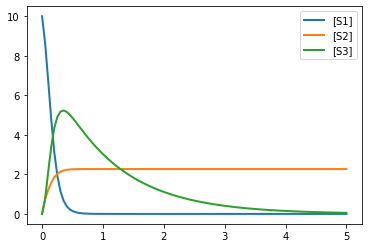

In [23]:
plotRR()

## 4: Calculate the approximation

This is unnecessary because ``control.forced_input`` takes initial conditions into account, which is the $\bar{\bf x}$. 

# Homework 1: Linear Approximations

Question 1)

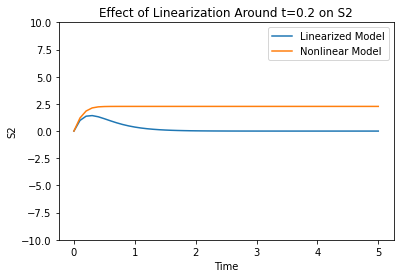

[10.  0.  0.]
      S1,  S2,  S3
S1 [[ -2, -15, -10],
S2  [  2, -15,   5],
S3  [  0,  45,  -6]]

Tests passed!


In [83]:
def compareSISOLinearization(operating_time, species_name, model=NONLINEAR_RR):
  """
  Plots the predicted values for a chemical species in a roadrunner model
  against the predicted values for that species in a linearized version of the
  model.

  Parameters
  ----------
  operating_time: A float indicating the point in simulation time that the model
  should be linearized around.
  species_name: A string corresponding to the name in the roadrunner model of
  the chemical species to be plotted
  model: A roadrunner model to be linearized and run for comparison to the
  linearized version. Must be a SISO model whose first chemical species is its
  input and whose final chemical species is its output. Must contain a chemical
  species with the name given in species_name.

  Returns
  -------
  A tuple containing the simulated response for the nonlinear model, the 
  simulated response for the linearized model, and the Jacobian around the 
  operating point
  """
  COMPARISON_TIME = 5
  PLOT_LOWER_BOUND = -10
  PLOT_UPPER_BOUND = 10
  # Obtaining state space matrices, around the operating point, from the Tellurium model
  model.reset()
  init_state_values = getStateValues(0, roadrunner=model)
  num_state_vars = len(init_state_values)
  if operating_time > 0:
    model.simulate(0,operating_time)
  A = model.getFullJacobian()
  B = np.reshape(np.array([1, 0, 0]), (num_state_vars,1))
  C = np.reshape(np.array([0, 0, 1]), (1,num_state_vars))
  D = 0
  # Constructing linearized model around the operating point and obtaining the response
  model_SS = control.StateSpace(A, B, C, D)
  times = [0.1*v for v in range((COMPARISON_TIME * 10) + 1)]
  linearized_response = control.forced_response(model_SS, times, X0=init_state_values)
  # Running nonlinear Tellurium model for comparison to linearized model
  model.reset()
  nonlinear_response = model.simulate(0,COMPARISON_TIME)
  target_species_index = np.where(np.array(model.getFloatingSpeciesIds()) == species_name)[0]
  # Plotting nonlinear and linearized models for the chosen chemical species
  plt.plot(linearized_response.t.flatten(), linearized_response.states[target_species_index].flatten(), label="Linearized Model")
  plt.plot(nonlinear_response[:,0], nonlinear_response[:,target_species_index + 1], label="Nonlinear Model")
  plt.xlabel("Time")
  plt.ylabel(species_name)
  plt.title("Effect of Linearization Around t=" + str(operating_time) + " on " + species_name)
  plt.legend()
  plt.ylim([PLOT_LOWER_BOUND, PLOT_UPPER_BOUND])
  plt.show()
  return (nonlinear_response, linearized_response, A)

#tests
function_data = compareSISOLinearization(0.2,'S2')
NONLINEAR_RR.reset()
test_nonlinear_data = NONLINEAR_RR.simulate(0,5)
NONLINEAR_RR.reset()
init_values = getStateValues(0)
NONLINEAR_RR.simulate(0,0.2)
test_linearization = control.StateSpace(NONLINEAR_RR.getFullJacobian(),
                                        np.reshape(np.array([1, 0, 0]), (3,1)),
                                        np.reshape(np.array([0, 0, 1]), (1,3)),
                                        0)
test_linearized_data = control.forced_response(test_linearization,
                                               np.linspace(0,5,51),
                                               X0=init_values)
assert (function_data[0] == test_nonlinear_data).all()
assert (function_data[1].states == test_linearized_data.states).all()
assert (function_data[2] == NONLINEAR_RR.getFullJacobian()).all()
plt.close()
print(init_values)
NONLINEAR_RR.reset()
print(NONLINEAR_RR.getFullJacobian())
print("Tests passed!")

Question 2)

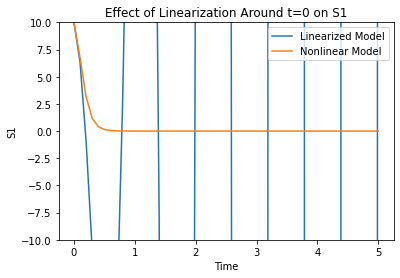

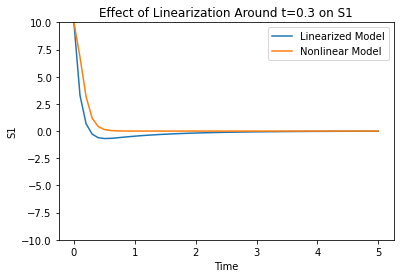

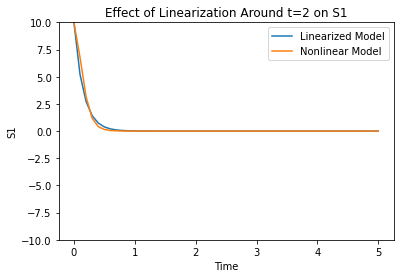

In [84]:
#@title
response_vals = compareSISOLinearization(0, 'S1')
initial_jacobian = response_vals[2]
response_vals = compareSISOLinearization(0.3, 'S1')
intermediate_jacobian = response_vals[2]
response_vals = compareSISOLinearization(2, 'S1')
long_term_jacobian = response_vals[2]

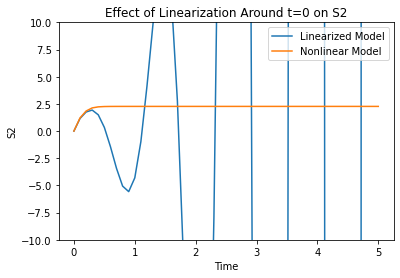

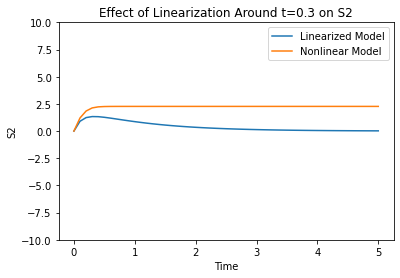

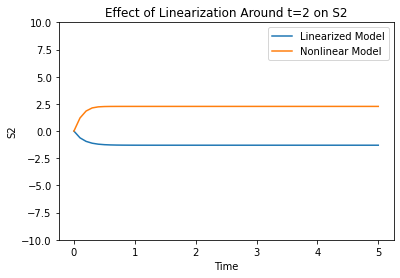

In [85]:
#@title
response_vals = compareSISOLinearization(0, 'S2')
response_vals = compareSISOLinearization(0.3, 'S2')
response_vals = compareSISOLinearization(2, 'S2')

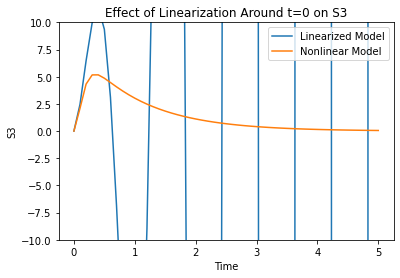

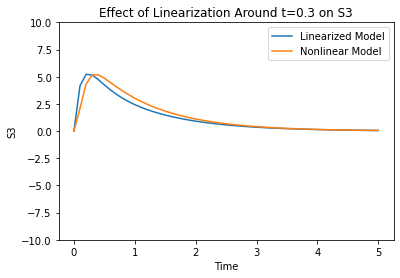

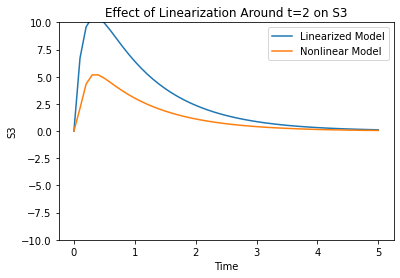

In [86]:
#@title
response_vals = compareSISOLinearization(0, 'S3')
response_vals = compareSISOLinearization(0.3, 'S3')
response_vals = compareSISOLinearization(2, 'S3')

In [72]:
print(initial_jacobian)
print(intermediate_jacobian)
print(long_term_jacobian)

      S1,  S2,  S3
S1 [[ -2, -15, -10],
S2  [  2, -15,   5],
S3  [  0,  45,  -6]]

           S1,       S2,       S3
S1 [[ -10.362, -1.76577, -1.17718],
S2  [ 1.38808, -1.76577, 0.588591],
S3  [ 7.00246,  5.29732, -1.58859]]

             S1,           S2,          S3
S1 [[  -6.51891, -1.38306e-06, -9.2204e-07],
S2  [ -0.847377, -1.38306e-06,  4.6102e-07],
S3  [   9.65649,  4.14918e-06,          -1]]



Question 3)

By far the largest discepencies between the original model and the linearized version of it are found when t=0 is used as the operating point. At t=0, the Jacobian is:

\begin{bmatrix}
-2 & -15 & -10 \\
2 & -15 & 5 \\
0 & 45 & -6
\end{bmatrix}

From this, we can see that the linearized model has extremely large gradients for how the changing species concentrations affect the reaction rates. As can be seen in the above plots, the linearized model has rates so large as to allow the concentrations to become highly negative. As the concentrations become negative, S1's rate becomes highly positive despite having a purely negative gradient, changing the behavior of S1 over time from an exponential decay to an exponentially growing oscillation. As a result of this, an extreme discrepency occurs between the linearization and the original model as soon as time exceeds 0.1 (the point where S1 becomes negative due to the linearization's approximations).

Aside from this, the second largest discrepency between the two models is the concentration of S2 when the model is linearized around t=2. At this operating point, the Jacobian is:

\begin{bmatrix}
-6.51891 & -1.38306e-06 & -9.2204e-07 \\
-0.847377 & -1.38306e-06 &  4.6102e-07\\
9.65649 & 4.14918e-06 & -1
\end{bmatrix}

From this, it can be seen that as S3 decreases to its steady state value, the linearization will decrease S2 to slightly below 0 as seen in the above plots. This generates a large discrepency between the nonlinear and linearized S2 since the linearized S2 does not properly account for the fact S2, at the operating point in the nonlinear model, has a stable value of approximately 2.5. As a result of properly capturing the stability of S2 but not the value of S2 once it reached stability, the linearized model keeps S2 close to 0.